In [12]:
import os

import wavio
import numpy as np
from scipy.fftpack import dct

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
path = 'C:/Users/Alex/Desktop/VAD/speech_dataset/'
files = os.listdir(path)
num_files = len(files)

In [14]:
# Step 1: pre-emphasis
def pre_emphasis(signal, coef_pre_emphasis):
    emphasized_signal = np.append(signal[0], signal[1:] - coef_pre_emphasis * signal[:-1])
    
    return emphasized_signal

In [15]:
# Step 2: framing
def Framing(emphasized_signal, frame_size, frame_stride, sample_rate):
    signal_length = len(emphasized_signal)
    frame_length = int(frame_size * sample_rate)
    step_length = int(frame_stride * sample_rate)
    num_frames = int(np.floor((signal_length - frame_length) / step_length) + 1)
    
    begin_frame = 0
    end_frame = frame_length
    frames = np.zeros((num_frames, frame_length))
    for i in range(num_frames):
        frames[i][:] = emphasized_signal[begin_frame:end_frame]
        begin_frame += step_length
        end_frame += step_length
        
    return frames, frame_length

In [16]:
# Step 3: Window
def Window(frames, frame_length):
    frames *= np.hamming(frame_length)
    
    return frames

In [17]:
# Step 4: Fourier-Transform and Power Spectrum
def Power_Spectrum(frames, NFFT):
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    
    return pow_frames

In [18]:
# Step 5: Filter Banks
def Filter_Banks(pow_frames, nfilt, NFFT, sample_rate):
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    return filter_banks

In [19]:
# Step 6: Mel-frequency Cepstral Coefficients (MFCCs)
def MFCC(filter_banks, num_ceps, cep_lifter):
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
    
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift  #*
    
    return mfcc

In [20]:
alpha = 0.97
frame_size = 0.025
frame_step = 0.01
NFFT = 256
nfilt = 40
cep_lifter = 22
num_ceps = 12
mfcc_feat = np.zeros((1, num_ceps + 1))

for i in range(num_files):
    
    wav = wavio.read(path + files[i])
    data = wav.data
    sample_rate = wav.rate
    
    # pre-emphasis:
    pre_emphasis_data = pre_emphasis(data, alpha)
    
    # Framing:
    samples_in_frames, frame_length = Framing(pre_emphasis_data, frame_size, frame_step, sample_rate)
    
    # Window:
    win_frames = Window(samples_in_frames, frame_length)
    
    # Fourier-Transform and Power Spectrum:
    pow_frames = Power_Spectrum(win_frames, NFFT)
    
    # Filter Banks:
    filter_banks = Filter_Banks(pow_frames, nfilt, NFFT, sample_rate)
    
    # Mel-frequency Cepstral Coefficients (MFCCs):
    mfcc = MFCC(filter_banks, num_ceps, cep_lifter)
    
    # Mean Normalization:
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    
    
    # Form dataset for writing in file:
    name_to_str = str(files[i])
    label = int(name_to_str[-5])
    
    dataset_on_sample = np.zeros((mfcc.shape[0], mfcc.shape[1] + 1))
    for j in range(mfcc.shape[0]):
        dataset_on_sample[j][0] = label
        dataset_on_sample[j][1:] = mfcc[j][:]
    
    mfcc_feat = np.concatenate((mfcc_feat, dataset_on_sample), axis=0)

In [21]:
mfcc_features = np.delete(mfcc_feat, 0, axis=0)
np.savetxt('mfcc_features.txt', mfcc_features)

Text(0.5, 1.0, 'the spectrum image')

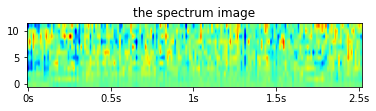

In [22]:
plt.subplot(312)
#filter_banks -= (np.mean(filter_banks,axis=0) + 1e-8)
x = mfcc
plt.imshow(x.T, cmap=plt.cm.jet, aspect='auto')
plt.xticks(np.arange(0, (x.T).shape[1],
int((x.T).shape[1] / 4)),
['0s', '0.5s', '1s', '1.5s','2.5s','3s','3.5'])
ax = plt.gca()
ax.invert_yaxis()
plt.title('the spectrum image')